In [1]:
import pandas as pd 
import numpy as np 
import sklearn
#from google.colab import files, drive, data_table
#from google.colab.data_table import *
from lightgbm import *
from sklearn.ensemble import *
from sklearn.ensemble import *
from sklearn.neural_network import *
from sklearn.model_selection import *
from sklearn.naive_bayes import *
from xgboost import *
from sklearn.svm import *
from sklearn.linear_model import *
from genetic_selection import GeneticSelectionCV
from sklearn.metrics import *

from sklearn.tree import *
import warnings
from sklearn.utils import *
from yellowbrick.model_selection import * 
from yellowbrick.classifier import * 
import matplotlib.pyplot as plt
#from bayes_opt import *
#from mlxtend.feature_selection import *
import warnings
warnings.filterwarnings("ignore")
#import h2o
##from h2o.automl import H2OAutoML
##h2o.init()

mcc = make_scorer(matthews_corrcoef)

<font color=red size=6>**Datos y Preprocesamiento**

In [2]:
D = pd.read_csv("heart_failure_clinical_records_dataset.csv")
all_var = D.columns
all_var = list(all_var)
all_var.remove("DEATH_EVENT")
all_var.remove("time")
catcols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
numcols = set(all_var) - set(catcols)
numcols = list(numcols)
print(numcols, catcols)

#D["time"].describe()

['ejection_fraction', 'age', 'serum_creatinine', 'serum_sodium', 'creatinine_phosphokinase', 'platelets'] ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']


In [3]:
D[all_var].dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
dtype: object

In [4]:
from sklearn.preprocessing import * 

for col in numcols: 
    scaler = MinMaxScaler()
    D[col] = scaler.fit_transform(D[col].values.reshape(-1,1))

In [5]:
D.iloc[:,-1] = D.iloc[:,-1].astype(np.int64)
D[all_var]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,0.636364,0,0.071319,0,0.090909,1,0.290823,0.157303,0.485714,1,0
1,0.272727,0,1.000000,0,0.363636,0,0.288833,0.067416,0.657143,1,0
2,0.454545,0,0.015693,0,0.090909,0,0.165960,0.089888,0.457143,1,1
3,0.181818,1,0.011227,0,0.090909,0,0.224148,0.157303,0.685714,1,0
4,0.454545,1,0.017479,1,0.090909,0,0.365984,0.247191,0.085714,0,0
...,...,...,...,...,...,...,...,...,...,...,...
294,0.400000,0,0.004848,1,0.363636,1,0.157474,0.067416,0.857143,1,1
295,0.272727,0,0.229268,0,0.363636,0,0.296884,0.078652,0.742857,0,0
296,0.090909,0,0.259888,1,0.696970,0,0.869075,0.033708,0.714286,0,0
297,0.090909,0,0.304925,0,0.363636,0,0.139290,0.101124,0.771429,1,1


In [6]:
X = D[all_var] ; y = D["DEATH_EVENT"].values

<font color=red size=6>**Regresión Logística, Referencia**

In [7]:
rkf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2)
clf = LogisticRegression(solver = "liblinear")
cv_score = np.mean(cross_val_score(clf, X, y, cv = rkf, scoring = mcc))
print(cv_score)

0.2935014672390199


<font color=red size=6>**Regresión Logística + Selección de variables**

In [8]:
from sklearn.feature_selection import *
var_list = [] 
all_scores = [] 
for i in range(10):
    np.random.seed(i)
    sfm = SelectFromModel(estimator = clf, threshold=None, prefit=False, 
                       norm_order=1, max_features = 10)
    sfm.fit(X, y)
    modfeats = sfm.get_support()
  
  #print(modfeats)
    Xred = X.iloc[:,modfeats]
    cols = list(Xred.columns)
    var_list.append(cols)
  
    rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 20)
    this_score = np.mean(cross_val_score(clf, Xred, y, cv = rskf, scoring = mcc))
    print(this_score) 
    all_scores.append(this_score)

for i in range(10):
    if all_scores[i] == np.max(all_scores):
        print("These are the Best Features", var_list[i])
        select_feats = var_list[i]
        print("They scored: ", all_scores[i])
#print("Overall Average", np.mean(all_scores))

0.32762910257065775
0.3207525660279272
0.3153225808638617
0.32907719789724754
0.31586880001465667
0.3257563404279942
0.32847648620708675
0.322181733156496
0.3214410757457935
0.3181770611278721
These are the Best Features ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']
They scored:  0.32907719789724754


In [9]:
select_feats

['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']

<font color=red size=5>**Regresión Logística + Selección Sequencial de Variable (SFSS)**

In [10]:
import mlxtend
from mlxtend.feature_selection import *
clf = LogisticRegression(fit_intercept = False, solver = "liblinear")
report2 = pd.DataFrame()
varlist = [] 
no_var = [] 
metrics = [] 
for i in range(2,10):
    rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2)
  
    sfs = SequentialFeatureSelector(clf, k_features = i, 
                                    scoring = mcc,
                                    floating = True,
                                    forward = True, 
                                    cv = rskf)
    sfs.fit(X.values, y)
    sfeats = list(sfs.k_feature_names_)
    sfeats = [int(s) for s in sfeats]
    sfeats = X.iloc[:,sfeats].columns
    sfeats = list(sfeats)
    Xred = sfs.fit_transform(X.values,y)
  
    cvscore = np.mean(cross_val_score(clf, Xred, y, cv = rskf, scoring = mcc))


    varlist.append(sfeats)
    no_var.append(len(sfeats))
    metrics.append(cvscore)

report2["Feats"] = varlist
report2["No of feats"] = no_var
report2["Score" ]  = metrics
#DataTable(report2)
report2

,Feats,No of feats,Score
0,"[age, ejection_fraction]",2,0.345668
1,"[age, ejection_fraction, serum_creatinine]",3,0.406451
2,"[age, ejection_fraction, high_blood_pressure, ...",4,0.387731
3,"[age, creatinine_phosphokinase, ejection_fract...",5,0.363007
4,"[age, anaemia, creatinine_phosphokinase, eject...",6,0.349435
5,"[age, creatinine_phosphokinase, diabetes, ejec...",7,0.358507
6,"[age, anaemia, creatinine_phosphokinase, diabe...",8,0.313059
7,"[age, anaemia, creatinine_phosphokinase, diabe...",9,0.323201


In [11]:
report2["Score"] = np.round(report2["Score"],3)
report2.sort_values(by = "Score", ascending = False, inplace = True)
report2

,Feats,No of feats,Score
1,"[age, ejection_fraction, serum_creatinine]",3,0.406
2,"[age, ejection_fraction, high_blood_pressure, ...",4,0.388
3,"[age, creatinine_phosphokinase, ejection_fract...",5,0.363
5,"[age, creatinine_phosphokinase, diabetes, ejec...",7,0.359
4,"[age, anaemia, creatinine_phosphokinase, eject...",6,0.349
0,"[age, ejection_fraction]",2,0.346
7,"[age, anaemia, creatinine_phosphokinase, diabe...",9,0.323
6,"[age, anaemia, creatinine_phosphokinase, diabe...",8,0.313


In [12]:
scores = [] 
for i in range(len(report2)):  
    myvars = report2.iloc[i,0] ; print(myvars)
    X = D[myvars] ; y = y
    clf = LogisticRegression(solver = "liblinear", C = 6, tol = 1) 
    rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 100)
    score = np.mean(cross_val_score(clf, X, y, cv = rskf, scoring = "roc_auc"))
    scores.append(score) 
    print("Score es de", score)

print("-------------------")
for i in range(len(scores)):
    if scores[i] == np.max(scores):
        print("Max Score", scores[i]); print("Variable:", report2.iloc[i,0])

['age', 'ejection_fraction', 'serum_creatinine']
Score es de 0.7484160846560847
['age', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine']
Score es de 0.752530873015873
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine']
Score es de 0.753994761904762
['age', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine', 'smoking']
Score es de 0.7456264285714286
['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine']
Score es de 0.7560158465608465
['age', 'ejection_fraction']
Score es de 0.7247044444444445
['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine', 'serum_sodium', 'smoking']
Score es de 0.7408647619047619
['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine', 'serum_sodium']
Score es de 

<font color=red size=5>**Regresión Logística + SHAP**

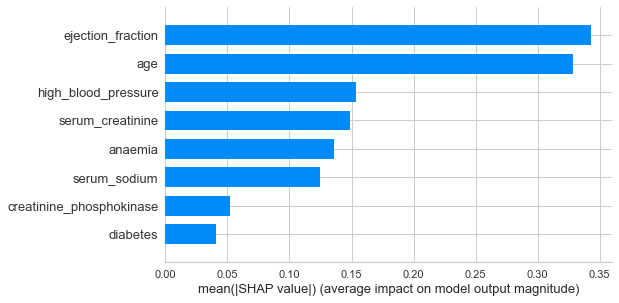

(299, 8)

In [13]:
import shap
from shap import LinearExplainer

clf = LogisticRegression(solver = "liblinear")
clf.fit(X, y)

explainer = shap.LinearExplainer(model= clf, data = X, masker=X)
shapvals = explainer.shap_values(X = X)
shap.summary_plot(shap_values = shapvals, features = X, plot_type = "bar")
X.shape

In [14]:
import numpy as np
vals= np.abs(shapvals).mean(0)
print(vals.shape)
print(len(X))
print(len(X.columns))
feature_importance = pd.DataFrame({'col_name': list(X.columns),'Importancia de la Variable': vals})
feature_importance.sort_values(by=['Importancia de la Variable'], ascending=False,inplace=True)
feature_importance


(8,)
299
8


,col_name,Importancia de la Variable
4,ejection_fraction,0.342764
0,age,0.328200
5,high_blood_pressure,0.153243
6,serum_creatinine,0.148792
1,anaemia,0.135571
7,serum_sodium,0.124236
2,creatinine_phosphokinase,0.052392
3,diabetes,0.040458


In [15]:
for i in range(1,11):
    covs = feature_importance["col_name"].values[:i]
    covs = list(covs)
    print(covs)
    print(np.mean(cross_val_score(clf, D[covs], y, cv = rskf, scoring = "balanced_accuracy")))

['ejection_fraction']
0.5057916666666666
['ejection_fraction', 'age']
0.5871083333333333
['ejection_fraction', 'age', 'high_blood_pressure']
0.5900591269841269
['ejection_fraction', 'age', 'high_blood_pressure', 'serum_creatinine']
0.5980698412698413
['ejection_fraction', 'age', 'high_blood_pressure', 'serum_creatinine', 'anaemia']
0.5888365079365079
['ejection_fraction', 'age', 'high_blood_pressure', 'serum_creatinine', 'anaemia', 'serum_sodium']
0.6106150793650793
['ejection_fraction', 'age', 'high_blood_pressure', 'serum_creatinine', 'anaemia', 'serum_sodium', 'creatinine_phosphokinase']
0.6027488095238095
['ejection_fraction', 'age', 'high_blood_pressure', 'serum_creatinine', 'anaemia', 'serum_sodium', 'creatinine_phosphokinase', 'diabetes']
0.6029091269841269
['ejection_fraction', 'age', 'high_blood_pressure', 'serum_creatinine', 'anaemia', 'serum_sodium', 'creatinine_phosphokinase', 'diabetes']
0.6045404761904761
['ejection_fraction', 'age', 'high_blood_pressure', 'serum_creatini

<font color=red size=5>**Regresión Logística + Algoritmos Genéticos (GA)**

In [36]:
estimator = LogisticRegression(solver = "liblinear", C = 6, tol = 1, fit_intercept = True)

from sklearn.model_selection import *
report = pd.DataFrame()
novar = [] 
chosen_var = [] 
cvscore = [] 
rkf = RepeatedStratifiedKFold(n_repeats = 20, n_splits = 5)
for i in range(2,11):
  
    selector = GeneticSelectionCV(estimator,
                                cv = rkf,
                                verbose = 0,
                                scoring = mcc,
                                max_features = i,
                                n_population = 200,
                                crossover_proba = 0.5,
                                mutation_proba = 0.2,
                                n_generations = 10,
                                crossover_independent_proba=0.5,
                                mutation_independent_proba=0.1,
                                #tournament_size = 3,
                                n_gen_no_change=10,
                                caching=True,
                                n_jobs=-1)
    selector = selector.fit(D[all_var], y)
    genfeats = D[all_var].columns[selector.support_]
    genfeats = list(genfeats)
    print("Variables seleccionadas:  ", genfeats)

    cv_score = selector.generation_scores_[-1]
    novar.append(len(genfeats)) 
    chosen_var.append(genfeats) 
    cvscore.append(cv_score)
report["# de variables"] = novar
report["Variables seleccionadas"] = chosen_var
report["Scores"] = cvscore

Variables seleccionadas:   ['age', 'ejection_fraction']
Variables seleccionadas:   ['age', 'ejection_fraction', 'serum_creatinine']
Variables seleccionadas:   ['age', 'diabetes', 'ejection_fraction', 'serum_creatinine']
Variables seleccionadas:   ['age', 'diabetes', 'ejection_fraction', 'serum_creatinine']
Variables seleccionadas:   ['age', 'diabetes', 'ejection_fraction', 'serum_creatinine']
Variables seleccionadas:   ['age', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'serum_creatinine']
Variables seleccionadas:   ['age', 'diabetes', 'ejection_fraction', 'serum_creatinine']
Variables seleccionadas:   ['age', 'diabetes', 'ejection_fraction', 'serum_creatinine']
Variables seleccionadas:   ['age', 'diabetes', 'ejection_fraction', 'serum_creatinine']


In [37]:
report["Scores"] = np.round(report["Scores"], 3)
report.sort_values(by = "Scores", ascending = False, inplace = True)
#report.index
ga_feats = report.iloc[0]["Variables seleccionadas"]
pd.DataFrame(report)
print(ga_feats)

['age', 'diabetes', 'ejection_fraction', 'serum_creatinine']


In [39]:
report

,# de variables,Variables seleccionadas,Scores
4,4,"[age, diabetes, ejection_fraction, serum_creat...",0.410
3,4,"[age, diabetes, ejection_fraction, serum_creat...",0.407
5,5,"[age, creatinine_phosphokinase, diabetes, ejec...",0.406
6,4,"[age, diabetes, ejection_fraction, serum_creat...",0.405
7,4,"[age, diabetes, ejection_fraction, serum_creat...",0.405
2,4,"[age, diabetes, ejection_fraction, serum_creat...",0.404
8,4,"[age, diabetes, ejection_fraction, serum_creat...",0.404
1,3,"[age, ejection_fraction, serum_creatinine]",0.395
0,2,"[age, ejection_fraction]",0.374


# Random Forest Baseline

In [22]:
clf = RandomForestClassifier(max_depth = 3)
rskf = RepeatedStratifiedKFold(n_repeats = 10, n_splits = 10)

#clf = LGBMClassifier(n_estimators = 41, max_depth=7)

#X = D[allfeats]; y = D.iloc[:,-1]
clf.fit(X,y)
print("roc auc on entire data set", roc_auc_score(y, clf.predict(X)))

print(np.mean(cross_val_score(clf, X, y, cv = rskf, scoring = "roc_auc")))

roc auc on entire data set 0.7220597290640395
Error Cuadrático Medio 0.18729096989966554
0.800375925925926


# Random Forest//Genetic Algo for feature selection

In [27]:
estimator = RandomForestClassifier(max_depth = 3)
from sklearn.model_selection import *
report = pd.DataFrame()
nofeats = [] 
chosen_feats = [] 
cvscore = [] 
rkf = RepeatedStratifiedKFold(n_repeats = 1, n_splits = 10)
for i in range(2,11):
  
  selector = GeneticSelectionCV(estimator,
                                cv = rkf,
                                verbose = 0,
                                scoring = "roc_auc",
                                max_features = i,
                                n_population = 30,
                                crossover_proba = 0.5,
                                mutation_proba = 0.2,
                                n_generations = 10,
                                crossover_independent_proba=0.5,
                                mutation_independent_proba=0.05,
                                tournament_size = 1,
                                n_gen_no_change = 5,
                                caching = True,
                                n_jobs=-1)
  selector = selector.fit(D[allfeats], y)

  print(selector.support_)

  genfeats = D[allfeats].columns[selector.support_]
  genfeats = list(genfeats)
  print(genfeats)

  X = D[genfeats] ; y = D.iloc[:,-1]
  clf = selector.estimator
  
  cv_score = selector.generation_scores_[-1]
  nofeats.append(len(genfeats)) 
  chosen_feats.append(genfeats) 
  cvscore.append(cv_score)

report["No of Feats"] = nofeats
report["Chosen Feats"] = chosen_feats
report["Scores"] = np.round(cvscore, 3)

#This took 568 seconds or 595 seconds  
#[False  True False  True  True False False  True  True False False  True]
#['anaemia', 'diabetes', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']
#Average CV score:  0.8202856225930681

[ True False False False  True False False False False False False]
['age', 'ejection_fraction']
[False False False False  True False False  True False False False]
['ejection_fraction', 'serum_creatinine']
[ True False False False  True False False  True  True False False]
['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']
[ True False False  True  True False False  True False False False]
['age', 'diabetes', 'ejection_fraction', 'serum_creatinine']
[ True False  True  True  True False  True  True False False False]
['age', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'platelets', 'serum_creatinine']
[ True  True False False  True False False  True False  True False]
['age', 'anaemia', 'ejection_fraction', 'serum_creatinine', 'sex']
[ True False  True  True  True  True False  True False False False]
['age', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine']
[ True False  True  True  True  True False  Tr

In [28]:
report.sort_values(by = "Scores", ascending = False, inplace = True)
report

,No of Feats,Chosen Feats,Scores
5,5,"[age, anaemia, ejection_fraction, serum_creati...",0.820
3,4,"[age, diabetes, ejection_fraction, serum_creat...",0.819
4,6,"[age, creatinine_phosphokinase, diabetes, ejec...",0.817
8,6,"[age, anaemia, creatinine_phosphokinase, eject...",0.817
7,8,"[age, creatinine_phosphokinase, diabetes, ejec...",0.809
2,4,"[age, ejection_fraction, serum_creatinine, ser...",0.807
6,6,"[age, creatinine_phosphokinase, diabetes, ejec...",0.806
1,2,"[ejection_fraction, serum_creatinine]",0.793
0,2,"[age, ejection_fraction]",0.787


In [29]:
for i in range(len(report)):
  featset = report.iloc[i,1] ; print(featset)
  clf = RandomForestClassifier(max_depth = 3)
  rskf = RepeatedStratifiedKFold(n_repeats = 10, n_splits = 10)
  X = D[featset]; y = D.iloc[:,-1]
  print(np.mean(cross_val_score(clf, X, y, cv = rskf, scoring = "roc_auc")))
  #.817

['age', 'anaemia', 'ejection_fraction', 'serum_creatinine', 'sex']
0.8083227513227514
['age', 'diabetes', 'ejection_fraction', 'serum_creatinine']
0.8076674603174604
['age', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'platelets', 'serum_creatinine']
0.8067685185185186
['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine']
0.8017153439153439
['age', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine', 'serum_sodium', 'sex']
0.7962708994708995
['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']
0.8037657407407406
['age', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine']
0.8046211640211641
['ejection_fraction', 'serum_creatinine']
0.7903751322751323
['age', 'ejection_fraction']
0.765402380952381


# Random Forest//SFSS for feature selection


In [33]:
clf = RandomForestClassifier(max_depth = 3)
report2 = pd.DataFrame()
featlist = [] 
no_feats = [] 
metrics = [] 
for i in range(1):
  rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1)
  
  sfs = SequentialFeatureSelector(clf, k_features = 5, 
                                  scoring = "roc_auc",
                                  floating = True,
                                  forward = False, 
                                  cv = rskf)
  sfs.fit(D[allfeats].values, y)
  sfeats = list(sfs.k_feature_names_)
  sfeats = [int(s) for s in sfeats]
  sfeats = D[allfeats].iloc[:,sfeats].columns
  sfeats = list(sfeats)
  Xred = sfs.fit_transform(D[allfeats].values,y)
  
  cvscore = np.mean(cross_val_score(clf, Xred, y, cv = rskf, scoring = "roc_auc"))


  featlist.append(sfeats)
  no_feats.append(len(sfeats))
  metrics.append(cvscore)

report2["Feats"] = featlist
report2["No of feats"] = no_feats
report2["Score" ]  = metrics
report2

,Feats,No of feats,Score
0,"[age, ejection_fraction, platelets, serum_crea...",5,0.802718


# Random Forest//Select From Model


In [35]:
feature_counts = [] 
feature_lists=[]
from sklearn.feature_selection import *
clf = RandomForestClassifier()
for i in range(50): 
  sfm = SelectFromModel(estimator = clf, threshold=None, prefit=False, norm_order=1, max_features = 11)
  sfm.fit(D[allfeats], y)
  modfeats = sfm.get_support()
  Xred = D[allfeats].iloc[:,modfeats]
  modfeats = list(Xred.columns)
  feature_lists.append(modfeats)



In [36]:
feature_lists = np.unique(feature_lists)
feature_lists

array(['age', 'creatinine_phosphokinase', 'ejection_fraction',
       'platelets', 'serum_creatinine', 'serum_sodium'], dtype='<U24')

# Random Forest//Shap Value 


roc auc score 0.984375


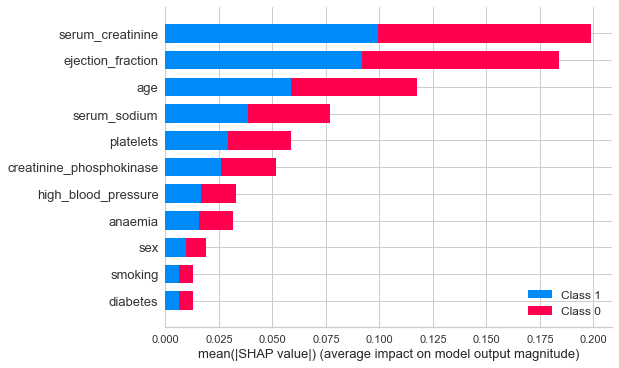

(299, 11)


In [39]:
import shap
#print(f)
X = D[allfeats];  y = D.iloc[:,-1]
clf = RandomForestClassifier(max_depth = 10)
clf.fit(X, y)
print("roc auc score", roc_auc_score(y, clf.predict(X)))
#print(confusion_matrix(y, clf.predict(X)))
explainer = shap.TreeExplainer(model= clf)
shapvals = explainer.shap_values(X = X)

shap.summary_plot(shap_values = shapvals, features = X, plot_type = "bar")


vals= np.abs(shapvals).mean(0)
print(vals.shape)


In [ ]:
import numpy as np
print(shapvals[0].shape)
vals = np.abs(shapvals[0]).mean(0)
print(vals.shape)
print(len(D.columns[:-1]))
feature_importance = pd.DataFrame()
feature_importance["feat names"] = D.columns[:-1]
feature_importance["feature_importance_vals"] = vals
feature_importance
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

(299, 12)
(12,)
12


,feat names,feature_importance_vals
11,time,0.187159
7,serum_creatinine,0.074065
4,ejection_fraction,0.064096
0,age,0.036117
8,serum_sodium,0.030376
6,platelets,0.023396
2,creatinine_phosphokinase,0.020421
9,sex,0.006996
5,high_blood_pressure,0.006337
1,anaemia,0.006173


In [ ]:
clf = RandomForestClassifier(max_depth = 3)
rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5)
for i in range(1,11):
  s = feature_importance["feat names"].values[:i]
  s = list(s)
  print("Features:  ", s)
  print(np.mean(cross_val_score(clf, D[s], y, cv = rskf, scoring = "roc_auc")))


Features:   ['time']
0.8407798941798944
Features:   ['time', 'serum_creatinine']
0.8990703703703704
Features:   ['time', 'serum_creatinine', 'ejection_fraction']
0.9141261904761905
Features:   ['time', 'serum_creatinine', 'ejection_fraction', 'age']
0.9096608465608466
Features:   ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium']
0.9180568783068782
Features:   ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium', 'platelets']
0.9152978835978836
Features:   ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium', 'platelets', 'creatinine_phosphokinase']
0.9121513227513227
Features:   ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium', 'platelets', 'creatinine_phosphokinase', 'sex']
0.9135306878306878
Features:   ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium', 'platelets', 'creatinine_phosphokinase', 'sex', 'high_blood_pressure']
0.9124534391534392
Features:   ['time', 'serum_creatinine

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


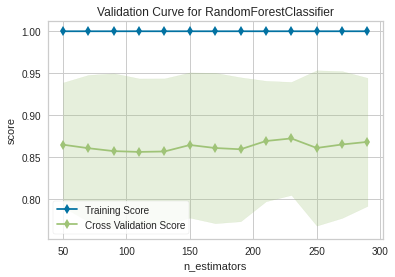

In [ ]:
visualizer = validation_curve(clf, X, y, cv = 10, 
                              scoring = "roc_auc", 
                              param_name="n_estimators", 
                              param_range=np.arange(50,300,20))


In [ ]:
scores = [] 
clf = RandomForestClassifier(max_depth = 10)
rskf = RepeatedStratifiedKFold(n_repeats = 10, n_splits = 10)
for f in feature_lists:
  X = D[f] ; y = y 
  this_score = np.mean(cross_val_score(clf, X, y, scoring = "roc_auc", cv = rskf))
  scores.append(this_score)
for i in range(len(scores)):
  if scores[i] == np.max(scores):
    print("Score", scores[i], "Features", feature_lists[i])

Score 0.9142465608465608 Features ['ejection_fraction', 'serum_creatinine', 'time']


# Random Forest HP Tuning with sk-deap

In [ ]:
myfeats = report2["Feats"]
myfeats = myfeats.values
myfeats = myfeats[0]
X = D[myfeats] 
X.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,time
0,0.636364,0.071319,0.090909,0.157303,0.000000
1,0.272727,1.000000,0.363636,0.067416,0.007117
2,0.454545,0.015693,0.090909,0.089888,0.010676
3,0.181818,0.011227,0.090909,0.157303,0.010676
4,0.454545,0.017479,0.090909,0.247191,0.014235


In [ ]:
paramgrid = {"max_depth": np.arange(3,10),
             "n_estimators": np.arange(50,500),
             "max_features": np.arange(2,5)
             }

np.random.seed(1)
clf = RandomForestClassifier()
from evolutionary_search import EvolutionaryAlgorithmSearchCV
cv = EvolutionaryAlgorithmSearchCV(estimator=clf,
                                   params=paramgrid,
                                   scoring="roc_auc",
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
cv.fit(X, y)

# H2o.ai autoML

In [ ]:

#F.drop(columns=[0], inplace = True)
F = h2o.H2OFrame(D)
F["DEATH_EVENT"] = F["DEATH_EVENT"].asfactor()
F

Parse progress: |█████████████████████████████████████████████████████████| 100%


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
50,1,111,0,20,0,210000,1.9,137,1,0,7,1
65,1,160,1,20,0,327000,2.7,116,0,0,8,1
90,1,47,0,40,1,204000,2.1,132,1,1,8,1
75,1,246,0,15,0,127000,1.2,137,1,0,10,1
60,1,315,1,60,0,454000,1.1,131,1,1,10,1
65,0,157,0,65,0,263358,1.5,138,0,0,10,1
80,1,123,0,35,1,388000,9.4,133,1,1,10,1


In [ ]:
used_feats = list(F.columns[:-1] )
print(used_feats)

aml = H2OAutoML(nfolds = 10, max_runtime_secs = 600, 
                balance_classes = True,
                max_models = 3)
aml.train(x = used_feats, y = "DEATH_EVENT", training_frame=F)
# Print Leaderboard (ranked by xval metrics)
aml.leaderboard
# (Optional) Evaluate performance on a test set

['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_3_AutoML_20201102_160350,0.923697,0.333008,0.84991,0.146321,0.320493,0.102715
StackedEnsemble_AllModels_AutoML_20201102_160350,0.917539,0.352676,0.835512,0.153992,0.326388,0.106529
XGBoost_1_AutoML_20201102_160350,0.90702,0.366875,0.808165,0.166025,0.340203,0.115738
XGBoost_2_AutoML_20201102_160350,0.890343,0.385642,0.79751,0.182215,0.347706,0.120899


In [ ]:
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20201102_160350


Model Summary: 


,,number_of_trees
0,,41.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.029782174346906352
RMSE: 0.1725751266750407
LogLoss: 0.12588370471438717
Mean Per-Class Error: 0.02273193760262726
AUC: 0.9957922824302136
AUCPR: 0.9899488860481507
Gini: 0.9915845648604271

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42505377531051636: 


,,0,1,Error,Rate
0,0,198.0,5.0,0.0246,(5.0/203.0)
1,1,2.0,94.0,0.0208,(2.0/96.0)
2,Total,200.0,99.0,0.0234,(7.0/299.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.425054,0.964103,98.0
1,max f2,0.292440,0.975610,107.0
2,max f0point5,0.560216,0.970982,87.0
3,max accuracy,0.425054,0.976589,98.0
4,max precision,0.997056,1.000000,0.0
5,max recall,0.292440,1.000000,107.0
6,max specificity,0.997056,1.000000,0.0
7,max absolute_mcc,0.425054,0.946986,98.0
8,max min_per_class_accuracy,0.425054,0.975369,98.0
9,max mean_per_class_accuracy,0.425054,0.977268,98.0



Gains/Lift Table: Avg response rate: 32.11 %, avg score: 32.24 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010033,0.992077,3.114583,3.114583,1.000000,0.994379,1.000000,0.994379,0.031250,0.031250,211.458333,211.458333,0.031250
1,2,0.020067,0.990834,3.114583,3.114583,1.000000,0.991767,1.000000,0.993073,0.031250,0.062500,211.458333,211.458333,0.062500
2,3,0.030100,0.988107,3.114583,3.114583,1.000000,0.990024,1.000000,0.992057,0.031250,0.093750,211.458333,211.458333,0.093750
3,4,0.040134,0.980933,3.114583,3.114583,1.000000,0.986893,1.000000,0.990766,0.031250,0.125000,211.458333,211.458333,0.125000
4,5,0.050167,0.978098,3.114583,3.114583,1.000000,0.979497,1.000000,0.988512,0.031250,0.156250,211.458333,211.458333,0.156250
5,6,0.100334,0.947840,3.114583,3.114583,1.000000,0.963853,1.000000,0.976183,0.156250,0.312500,211.458333,211.458333,0.312500
6,7,0.150502,0.915605,3.114583,3.114583,1.000000,0.934384,1.000000,0.962250,0.156250,0.468750,211.458333,211.458333,0.468750
7,8,0.200669,0.858221,2.906944,3.062674,0.933333,0.884433,0.983333,0.942796,0.145833,0.614583,190.694444,206.267361,0.609657
8,9,0.301003,0.540386,3.010764,3.045370,0.966667,0.747293,0.977778,0.877628,0.302083,0.916667,201.076389,204.537037,0.906814
9,10,0.401338,0.179902,0.830556,2.491667,0.266667,0.334703,0.800000,0.741897,0.083333,1.000000,-16.944444,149.166667,0.881773




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.10271546409327958
RMSE: 0.3204925335998946
LogLoss: 0.3330084661235349
Mean Per-Class Error: 0.14632081280788178
AUC: 0.9236966338259441
AUCPR: 0.8499101946340186
Gini: 0.8473932676518883

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5143061876296997: 


,,0,1,Error,Rate
0,0,188.0,15.0,0.0739,(15.0/203.0)
1,1,21.0,75.0,0.2188,(21.0/96.0)
2,Total,209.0,90.0,0.1204,(36.0/299.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.514306,0.806452,88.0
1,max f2,0.065878,0.863309,170.0
2,max f0point5,0.764562,0.828313,57.0
3,max accuracy,0.514306,0.879599,88.0
4,max precision,0.997582,1.000000,0.0
5,max recall,0.065878,1.000000,170.0
6,max specificity,0.997582,1.000000,0.0
7,max absolute_mcc,0.514306,0.719994,88.0
8,max min_per_class_accuracy,0.241429,0.822917,111.0
9,max mean_per_class_accuracy,0.514306,0.853679,88.0



Gains/Lift Table: Avg response rate: 32.11 %, avg score: 30.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010033,0.993169,3.114583,3.114583,1.000000,0.996263,1.000000,0.996263,0.031250,0.031250,211.458333,211.458333,0.031250
1,2,0.020067,0.986953,3.114583,3.114583,1.000000,0.990111,1.000000,0.993187,0.031250,0.062500,211.458333,211.458333,0.062500
2,3,0.030100,0.984153,3.114583,3.114583,1.000000,0.986051,1.000000,0.990808,0.031250,0.093750,211.458333,211.458333,0.093750
3,4,0.040134,0.983014,3.114583,3.114583,1.000000,0.983709,1.000000,0.989033,0.031250,0.125000,211.458333,211.458333,0.125000
4,5,0.050167,0.979648,2.076389,2.906944,0.666667,0.981939,0.933333,0.987614,0.020833,0.145833,107.638889,190.694444,0.140907
5,6,0.100334,0.919855,2.699306,2.803125,0.866667,0.952042,0.900000,0.969828,0.135417,0.281250,169.930556,180.312500,0.266472
6,7,0.150502,0.848766,3.114583,2.906944,1.000000,0.886983,0.933333,0.942213,0.156250,0.437500,211.458333,190.694444,0.422722
7,8,0.200669,0.760679,2.699306,2.855035,0.866667,0.813261,0.916667,0.909975,0.135417,0.572917,169.930556,185.503472,0.548286
8,9,0.301003,0.502392,2.076389,2.595486,0.666667,0.622145,0.833333,0.814032,0.208333,0.781250,107.638889,159.548611,0.707358
9,10,0.401338,0.216025,0.519097,2.076389,0.166667,0.307168,0.666667,0.687316,0.052083,0.833333,-48.090278,107.638889,0.636289




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.89,0.09169192,0.9,0.96666664,0.93333334,0.6666667,0.9,0.9,0.8333333,0.8666667,0.93333334,1.0
1,auc,0.9245805,0.06891887,0.8803828,0.9886364,0.945,0.75661373,0.9351852,0.9537037,0.925,0.9047619,0.95652175,1.0
2,aucpr,0.8518471,0.14259882,0.8722648,0.9736599,0.9064802,0.5086436,0.8972236,0.94098765,0.8802919,0.7515379,0.7873816,1.0
3,err,0.11,0.09169192,0.1,0.033333335,0.06666667,0.33333334,0.1,0.1,0.16666667,0.13333334,0.06666667,0.0
4,err_count,3.3,2.7507575,3.0,1.0,2.0,10.0,3.0,3.0,5.0,4.0,2.0,0.0
5,f0point5,0.8346806,0.14200431,0.88235295,0.9722222,0.9,0.5294118,0.859375,0.9375,0.71428573,0.73770493,0.81395346,1.0
6,f1,0.8563658,0.094037116,0.85714287,0.93333334,0.9,0.64285713,0.88,0.85714287,0.8,0.8181818,0.875,1.0
7,f2,0.8913468,0.062491108,0.8333333,0.8974359,0.9,0.8181818,0.90163934,0.7894737,0.90909094,0.9183673,0.9459459,1.0
8,lift_top_group,2.872132,1.160851,2.7272727,3.75,3.0,0.0,2.5,2.5,3.0,3.3333333,4.285714,3.625
9,logloss,0.33222908,0.15695447,0.42412266,0.13457863,0.27377892,0.6623437,0.39990854,0.3157126,0.34807083,0.3669409,0.2976382,0.09919596



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-11-02 16:04:00,2.050 sec,0.0,0.500000,0.693147,0.500000,0.321070,1.000000,0.678930
1,,2020-11-02 16:04:00,2.068 sec,5.0,0.300354,0.325312,0.955434,0.926275,3.114583,0.100334
2,,2020-11-02 16:04:00,2.080 sec,10.0,0.262905,0.250175,0.970187,0.947590,3.114583,0.083612
3,,2020-11-02 16:04:00,2.090 sec,15.0,0.236774,0.205506,0.982143,0.966516,3.114583,0.060201
4,,2020-11-02 16:04:00,2.100 sec,20.0,0.215861,0.179706,0.989994,0.981046,3.114583,0.043478
5,,2020-11-02 16:04:00,2.110 sec,25.0,0.202846,0.161687,0.992252,0.984234,3.114583,0.036789
6,,2020-11-02 16:04:00,2.138 sec,30.0,0.192229,0.148948,0.994202,0.987115,3.114583,0.030100
7,,2020-11-02 16:04:00,2.149 sec,35.0,0.182119,0.138427,0.995946,0.990709,3.114583,0.026756
8,,2020-11-02 16:04:00,2.160 sec,40.0,0.173984,0.127549,0.995587,0.989796,3.114583,0.030100
9,,2020-11-02 16:04:00,2.184 sec,41.0,0.172575,0.125884,0.995792,0.989949,3.114583,0.023411



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,time,233.815079,1.000000,0.432664
1,serum_creatinine,78.841904,0.337198,0.145893
2,ejection_fraction,75.410309,0.322521,0.139543
3,age,40.633396,0.173784,0.075190
4,creatinine_phosphokinase,34.951736,0.149485,0.064677
5,serum_sodium,32.242455,0.137897,0.059663
6,platelets,31.006721,0.132612,0.057377
7,diabetes,5.154655,0.022046,0.009538
8,sex,4.830815,0.020661,0.008939
9,smoking,3.520566,0.015057,0.006515


# Pycaret


In [ ]:
D.columns
allfeats
used_feats = select_feats+ ["DEATH_EVENT"]
#used_feats = _feats + ["DEATH_EVENT"] ; print(used_feats)


In [ ]:
from pycaret.datasets import get_data
from pycaret.classification import *
D.head(2)
ename = setup(data = D[used_feats], target = "DEATH_EVENT", 
              test_data = None,
              fold_strategy = "stratifiedkfold",
              fold_shuffle = True, 
              use_gpu = True,
              normalize = True,
              categorical_features = None,
              
              #pca = True,
              #pca_method = "kernel",
              #pca_components = 5, 
              preprocess = False,
              html = True,
              #POLYNOMIAL
              #polynomial_features = True,
              #polynomial_degree = 2, 
              #transformation
              
              #transformation = True,
              #feature_selection = True, 
              feature_interaction = True,
          
              fix_imbalance = True,
              #fix_imbalance_method  = imblearn.over_sampling.SMOTE(),
              imputation_type='simple',
              verbose = True,
              )

,Description,Value
0,session_id,4956
1,Target,DEATH_EVENT
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(299, 7)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,0
8,Transformed Train Set,"(209, 6)"
9,Transformed Test Set,"(90, 6)"


In [ ]:
from sklearn.model_selection import *
rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 20)
best_model = compare_models(sort = "MCC", round = 2, 
                            fold = rskf,
                            #include = ["rf","catboost"],
                            #n_select = 1
                            )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.75,0.78,0.50,0.63,0.55,0.38,0.39,0.89
catboost,CatBoost Classifier,0.75,0.76,0.47,0.64,0.54,0.37,0.39,0.82
et,Extra Trees Classifier,0.73,0.77,0.47,0.61,0.52,0.34,0.35,0.89
lda,Linear Discriminant Analysis,0.73,0.76,0.41,0.63,0.49,0.32,0.34,0.01
knn,K Neighbors Classifier,0.73,0.74,0.44,0.59,0.50,0.32,0.33,0.04
lightgbm,Light Gradient Boosting Machine,0.72,0.71,0.48,0.57,0.51,0.32,0.33,0.03
ridge,Ridge Classifier,0.73,0.00,0.35,0.66,0.44,0.29,0.32,0.01
gbc,Gradient Boosting Classifier,0.72,0.70,0.46,0.57,0.50,0.30,0.31,0.09
svm,SVM - Linear Kernel,0.71,0.00,0.38,0.60,0.40,0.25,0.29,0.01
ada,Ada Boost Classifier,0.71,0.68,0.45,0.55,0.49,0.29,0.29,0.12


In [ ]:
clf1 = XGBClassifier()
clf2 = LGBMClassifier()
for clf in [clf1, clf2]:
  rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 50)
  print(np.round(np.mean(cross_val_score(clf, D[used_feats[:-1]], y, scoring = mcc, cv = rskf)),3))

0.353
0.369


In [ ]:
tuned_mod = tune_model(mymod, optimize = "MCC", 
                       search_library = "scikit-learn",
                       search_algorithm = "grid"
                       )

In [ ]:
folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 50)
dt = create_model("catboost", fold = folds) #bagging = .7227 boosting . 635
#bagged_dt = ensemble_model(dt, method = "Bagging")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7619,0.7560,0.4615,0.6667,0.5455,0.3913,0.4034
1,0.6905,0.7294,0.3846,0.5000,0.4348,0.2266,0.2303
2,0.7857,0.8170,0.6154,0.6667,0.6400,0.4878,0.4886
3,0.7619,0.7480,0.3846,0.7143,0.5000,0.3617,0.3916
4,0.7317,0.7500,0.3846,0.6250,0.4762,0.3093,0.3258
...,...,...,...,...,...,...,...
247,0.7619,0.7560,0.4615,0.6667,0.5455,0.3913,0.4034
248,0.8095,0.7878,0.6154,0.7273,0.6667,0.5346,0.5383
249,0.8049,0.8516,0.6154,0.7273,0.6667,0.5301,0.5338
Mean,0.7497,0.7559,0.4775,0.6435,0.5385,0.3740,0.3871


In [ ]:
top3 = compare_models(n_select = 2, include = ["catboost", "rf"])
blender = stack_models(top3)

# Baseline (Random Search CV)


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, 
                                            num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(np.arange(2,6))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, n_iter = 100, 
                               cv = rskf, verbose=2, 
                               scoring = "roc_auc",
                               random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 100 folds for each of 100 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 6841 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 7934 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 9109 tasks      | 

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=None),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_we...
                   param_distrib

In [ ]:
rf_random.best_params_
bestclf = rf_random.best_estimator_
print(np.mean(cross_val_score(bestclf, X, y, 
                              cv = rskf, 
                              scoring = "roc_auc")))

0.9123714285714286


# Bayesian Hyperopt : XGBoost 

In [ ]:
#!pip install bayesian-optimization
X.head(2)

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,time
0,0.636364,0.071319,0.090909,0.157303,0.000000
1,0.272727,1.000000,0.363636,0.067416,0.007117


In [ ]:
from lightgbm import *
from bayes_opt import *
from sklearn.metrics import *

covariates = X; target = y
def lgb_trainer(#num_leaves, 
                scale_pos_weight,
                colsample_bytree,
                learning_rate, 
                max_depth, 
                n_estimators, 
                reg_lambda,
                reg_alpha, 
                subsample):
  
  lgb = XGBClassifier(#device_type = "cpu",
                      #boosting_type = "gbdt",
                      #objective = "binary",
                      scale_pos_weight = scale_pos_weight,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample, 
                      reg_alpha = reg_alpha, 
                      reg_lambda = reg_lambda,
                      n_estimators = int(n_estimators),
                      max_depth = int(max_depth),
                      learning_rate = learning_rate)
                    
  #fit_params = {"categorical_feature": catcols}
  
  rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2)
  scores = cross_val_score(lgb, covariates, target, 
                           cv = rskf, 
                           scoring = "roc_auc") 
  return np.mean(scores)

def lgb_opt():
  optimizer = BayesianOptimization(
  f = lgb_trainer,
  pbounds = {"scale_pos_weight": (0.4, 0.6),
             "reg_alpha": (0, 2),
             "subsample": (0.8, 1.0),
             "n_estimators" : (50,300),
             "max_depth": (2,12),
             "reg_lambda": (0, 2),
             "learning_rate" : (0.01, 0.50),
             "colsample_bytree": (0.8, 1.)
            }
  )
  optimizer.maximize(n_iter = 30, init_points = 2)
  print("Final result:", optimizer.max)
  return optimizer.max

lgb_results = lgb_opt()
print(lgb_results)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9166   |  0.9542   |  0.164    |  6.233    |  52.39    |  1.844    |  1.129    |  0.548    |  0.8799   |
|  2        |  0.9091   |  0.8189   |  0.1035   |  4.589    |  208.4    |  0.784    |  1.564    |  0.5639   |  0.8986   |
|  3        |  0.9104   |  0.9163   |  0.04664  |  11.48    |  50.48    |  1.64     |  0.7683   |  0.5312   |  0.8713   |
|  4        |  0.9085   |  0.8144   |  0.2157   |  2.094    |  299.8    |  1.52     |  0.04241  |  0.5105   |  0.8671   |
|  5        |  0.903    |  0.8702   |  0.3009   |  2.085    |  51.8     |  0.09774  |  1.101    |  0.5656   |  0.8958   |
|  6        |  0.9149   |  0.9372   |  0.0961   |  11.62    |  122.6    |  1.87     |  1.816    |  0.5099   |  0.8906   |
|  7        |  0.911    

In [ ]:
lgb_results["params"]
for hp in ["n_estimators","max_depth"]:
  lgb_results["params"][hp] = int(lgb_results["params"][hp])
fparams = lgb_results["params"]
print(fparams)
rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)
clf = XGBClassifier(**fparams)
print(np.mean(cross_val_score(clf, X, y,
                              cv = rskf, 
                              scoring = "roc_auc")))

{'colsample_bytree': 0.9619417139934122, 'learning_rate': 0.03991882605688996, 'max_depth': 2, 'n_estimators': 270, 'reg_alpha': 1.8195428288095146, 'reg_lambda': 0.7119891837795551, 'scale_pos_weight': 0.40840476780235524, 'subsample': 0.8112429102110856}
0.9151584656084657


In [ ]:
covariates = X; target = y
def rf_trainer(n_estimators,
               min_samples_split, 
                min_samples_leaf,
                max_depth):
  
  rf = RandomForestClassifier(
                     min_samples_leaf = int(min_samples_leaf),
                     min_samples_split = int(min_samples_split),
                     n_estimators = int(n_estimators),
                     max_depth = int(max_depth)
                     )

  
  rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
  scores = cross_val_score(rf, covariates, target, 
                           cv = rskf,
                           scoring = "roc_auc") 
  return np.mean(scores)

def rf_opt():
  optimizer = BayesianOptimization(
  f = rf_trainer,
  pbounds = {
             "min_samples_split": (2,10),
             "min_samples_leaf": (1,5),
             "n_estimators" : (50,300),
             "max_depth": (2,10),
            
            }
  )
  optimizer.maximize(n_iter = 20, init_points = 2)
  print("Final result:", optimizer.max)
  return optimizer.max

rf_results = rf_opt()
print(rf_results)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.919    |  2.332    |  1.424    |  2.4      |  58.68    |
|  2        |  0.9078   |  6.103    |  1.014    |  4.76     |  278.1    |
|  3        |  0.906    |  9.286    |  3.362    |  7.453    |  50.05    |
|  4        |  0.9144   |  2.042    |  4.978    |  2.953    |  159.4    |
|  5        |  0.9176   |  2.205    |  1.015    |  9.553    |  69.41    |
|  6        |  0.9135   |  2.105    |  1.104    |  2.56     |  115.7    |
|  7        |  0.9128   |  2.001    |  4.665    |  6.347    |  299.8    |
|  8        |  0.9123   |  9.712    |  2.56     |  8.321    |  134.9    |
|  9        |  0.9077   |  2.502    |  1.499    |  9.739    |  218.2    |
|  10       |  0.9175   |  9.603    |  4.446    |  9.268    |  299.2    |
|  11       |  0.916    |  2.298    |  4.864    |  4.318    |  83.49    |
|  12       |  0.9143   |  9.872    | 

In [ ]:
# for f in ["n_estimators", "max_depth" ,"min_samples_leaf", "min_samples_split"]:
#   #print(f)
#   rf_results["params"][f] = int(rf_results["params"][f])
# bparams = rf_results["params"]
!pip install catboost_info
from catboost import *
rskf = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 1)
clf = CatBoostClassifier() #RandomForestClassifier()
clf

print(np.mean(cross_val_score(clf, X, y, cv = rskf, scoring = mcc)))

# Visualizations


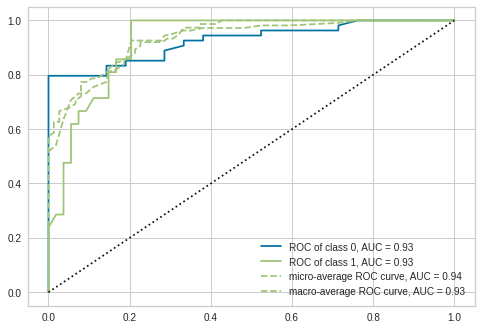

In [ ]:
X = D[["ejection_fraction", "serum_creatinine", "time", "age"]]
y = y

clf = RandomForestClassifier()
visualizer = ROCAUC(clf, classes=[0,1])
trainx, valx, trainy, valy = train_test_split(X, y, shuffle = True)
trainx.head
visualizer.fit(trainx, trainy)        
visualizer.score(valx, valy) 

plt.legend()

          


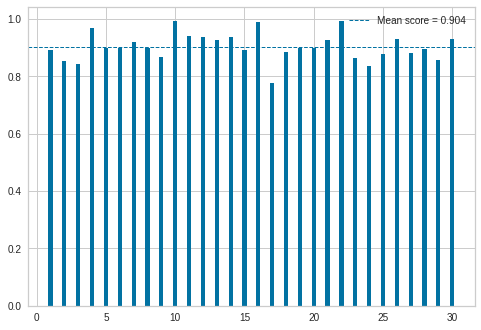

In [ ]:

rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
visualizer = CVScores(clf, cv = rskf, scoring='roc_auc')
visualizer.fit(X, y)  
plt.legend()      
plt.show() 

# Other methods

In [ ]:
from skfeature.function.information_theoretical_based import MRMR
X

,ejection_fraction,serum_creatinine,time
0,0.090909,0.157303,0.000000
1,0.363636,0.067416,0.007117
2,0.090909,0.089888,0.010676
3,0.090909,0.157303,0.010676
4,0.090909,0.247191,0.014235
...,...,...,...
294,0.363636,0.067416,0.946619
295,0.363636,0.078652,0.950178
296,0.696970,0.033708,0.975089
297,0.363636,0.101124,0.982206


In [ ]:
X = D[allfeats]
for i in range(2,11):
  idx,_,_ = MRMR.mrmr(X.values, y, n_selected_features = i)
  s = list(X.iloc[:,idx].columns) ; print("Features:   ", s)
  print(np.mean(cross_val_score(clf, X[s], y, cv = rskf, scoring = "roc_auc")))

In [ ]:
from skfeature.function.statistical_based.gini_index import gini_index
gin = gini_index(X.values, y)
ranks = feature_ranking(gin)
ranks
ranks = X.iloc[:,ranks].columns
ranks = list(ranks)
ranks

['time',
 'serum_creatinine',
 'ejection_fraction',
 'age',
 'serum_sodium',
 'creatinine_phosphokinase',
 'platelets',
 'high_blood_pressure',
 'anaemia',
 'smoking',
 'sex',
 'diabetes']

In [ ]:
for i in range(1,11):
  s = ranks[:i]
  print("Features:   ", s, np.mean(cross_val_score(clf, X[s], y, cv = rskf, scoring  = "balanced_accuracy")))


Features:    ['time'] 0.781242297817715
Features:    ['time', 'serum_creatinine'] 0.7765930680359436
Features:    ['time', 'serum_creatinine', 'ejection_fraction'] 0.8097339537869064
Features:    ['time', 'serum_creatinine', 'ejection_fraction', 'age'] 0.8092657252888319
Features:    ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium'] 0.8101826059050065
Features:    ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium', 'creatinine_phosphokinase'] 0.8006145699614889
Features:    ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium', 'creatinine_phosphokinase', 'platelets'] 0.8048334403080872
Features:    ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium', 'creatinine_phosphokinase', 'platelets', 'high_blood_pressure'] 0.8085863286264441
Features:    ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium', 'creatinine_phosphokinase', 'platelets', 'high_blood_pressure', 'anaemia'] 0.809945442875